In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp gdrive/My\ Drive/x96_extrapolation/*.npy .
!cp -r gdrive/My\ Drive/tools/ .
!cp -r gdrive/My\ Drive/models/ .
!ls -l

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
total 5704992
drwx------ 3 root root       4096 May  6 21:15 gdrive
drwx------ 3 root root       4096 May  6 21:17 models
drwxr-xr-x 1 root root       4096 Apr 29 16:32 sample_data
drwx------ 3 root root       4096 May  6 21:17 tools
-rw------- 1 root root  584202368 May  6 21:16 X_test.npy
-rw------- 1 root root 1869364352 May  6 21:16 X_train.npy
-rw------- 1 root root  467361920 May  6 21:16 X_val.npy
-rw------- 1 root root  584202368 May  6 21:16 y_test.n

In [ ]:
!cp gdrive/My\ Drive/16/combined_2e-5/weights1 weights1

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import tools._my_tools as mt
import tools._torch_tools as tt
import models.loss as lo
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device is", device)
data_folder = "dataset_extrapolation/"

Device is cuda:0


In [5]:
X_train, y_train = mt.loadData("",train=True,typeF='float16')

Loading X_train.npy
Loading y_train.npy


In [2]:
X_train, y_train, X_val, y_val = mt.loadData(data_folder,train=True,val=True,typeF='float16')

Loading dataset_extrapolation/X_train.npy
Loading dataset_extrapolation/y_train.npy
Loading dataset_extrapolation/X_val.npy
Loading dataset_extrapolation/y_val.npy


In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.activation = nn.PReLU()
        
        self.conv_setup = {
            'kernel' : (3,3),
            'stride' : (1,1),
            'padding' : 1,
            'activation' : self.activation
        }
        self.pooling_setup = {
            'kernel_size' : (2,2),
            'stride' : (2,2)
        }
        self.upsample_setup = {
            'scale_factor' : 2,
            'mode' : 'bilinear',
            'align_corners' : True
        }

        self.pooling_layer = nn.AvgPool2d(**self.pooling_setup)
        self.upsample_layer = nn.Upsample(**self.upsample_setup)
        
        self.conv32 = self._convBlock(3, 32, **self.conv_setup)
        self.conv64 = self._convBlock(32, 64, **self.conv_setup)
        self.conv128 = self._convBlock(64, 128, **self.conv_setup)
        self.conv256 = self._convBlock(128, 256, **self.conv_setup)
        self.conv256_256 = self._convBlock(256, 256, **self.conv_setup)


        self.upsample256 = self._upsampleBlock(self.upsample_layer, 256, 256, **self.conv_setup)
        self.deconv128 = self._convBlock(256, 128, **self.conv_setup)
        self.upsample128 = self._upsampleBlock(self.upsample_layer, 128, 128, **self.conv_setup)
        self.deconv64 = self._convBlock(128, 64, **self.conv_setup)
        self.upsample64 = self._upsampleBlock(self.upsample_layer, 64, 64, **self.conv_setup)
        self.deconv32 = self._convBlock(64, 32, **self.conv_setup)
        self.upsample32 = self._upsampleBlock(self.upsample_layer, 32, 32, **self.conv_setup)
        self.deconv1 = self._convBlock(32, 1, kernel=(3,3), stride=(1,1), padding=1, activation=None)
    
    def predict(self,x,num_steps):
        assert x.shape[0] == 1
        assert x.shape[1] == 3
        
        def_shape = x.shape
        res = []
    
        for i in range(num_steps):
            out = self.forward(x)
            res.append(out)
            x = torch.cat((x[:,1:,:,:],out),1)
            
        res = torch.cat(res,dim=1)
        return res.view(1,num_steps,def_shape[2],def_shape[3])
    
    def forward(self, x):
        x32 = self.conv32(x)
        x32_p = self.pooling_layer(x32)
        x64 = self.conv64(x32_p)
        x64_p = self.pooling_layer(x64)
        x128 = self.conv128(x64_p)
        x128_p = self.pooling_layer(x128)
        x256 = self.conv256(x128_p)
        x256_p = self.pooling_layer(x256)

        x = self.conv256_256(x256_p)

        # expansion

        x = self.upsample256(x)
        x += x256
        x = self.deconv128(x)

        x = self.upsample128(x)
        x += x128
        x = self.deconv64(x)

        x = self.upsample64(x)
        x += x64
        x = self.deconv32(x)
        
        x = self.upsample32(x)
        x += x32
        x = self.deconv1(x)
        
        return x
    
    @staticmethod
    def _convBlock(in_channels, out_channels, kernel, stride, padding, activation):
        net = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel, stride, padding), nn.PReLU(),
            nn.Conv2d(in_channels, in_channels, kernel, stride, padding), nn.PReLU(),
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding)
        )
        if activation is not None:
            net = nn.Sequential(
                net, 
                nn.BatchNorm2d(out_channels),
                activation
            )
        return net
    @staticmethod
    def _upsampleBlock(upsample, in_channels, out_channels, kernel, stride, padding, activation):
        return nn.Sequential(
            upsample,
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding), nn.PReLU()
        )

class Training(tt.Training):
    def __init__(self,*args,**kwargs):
        super(Training,self).__init__(*args,**kwargs)
        
    def getBatch(self, offset, batch_size, val=False):
        input,target = super(Training,self).getBatch(offset, batch_size, val=val)
        target = target[:,:1,:,:]
        
        return input, target

In [6]:
model = Model()
model.load_state_dict(torch.load("16/weights30.pth"))
# loss = lo.CombinedLoss()
training = Training(model,device,X_train, y_train, X_val, y_val, loss_function=nn.L1Loss())
training.history = mt.fromCSV("16/history.csv")

In [7]:
try:
    training.fit(32,20,val=True, save="16/", save_off=30)
except KeyboardInterrupt:
    print("\n\nFinished training.")



====== TRAINING ======
===> Epoch[31](2112/2112): Loss: 0.0168	ETA 0:00:00	Epoch Loss: 0.0196
Epoch[31] finished in 0:02:34 with loss 0.019618837726849244
Validating on 16896 samples.
===> Validating (528/528):	ETA 0:00:00	Validation Loss: 0.0202
Validation loss = 0.0202

----------------------------

===> Epoch[32](2112/2112): Loss: 0.0168	ETA 0:00:00	Epoch Loss: 0.0195
Epoch[32] finished in 0:02:32 with loss 0.019522349529187053
Validating on 16896 samples.
===> Validating (528/528):	ETA 0:00:00	Validation Loss: 0.0202
Validation loss = 0.0202

----------------------------

===> Epoch[33](2112/2112): Loss: 0.0172	ETA 0:00:00	Epoch Loss: 0.0195
Epoch[33] finished in 0:02:34 with loss 0.0195094537074593
Validating on 16896 samples.
===> Validating (528/528):	ETA 0:00:00	Validation Loss: 0.0203
Validation loss = 0.0203

----------------------------

===> Epoch[34](2112/2112): Loss: 0.0169	ETA 0:00:00	Epoch Loss: 0.0195
Epoch[34] finished in 0:02:32 with loss 0.019474315369293574
Valid

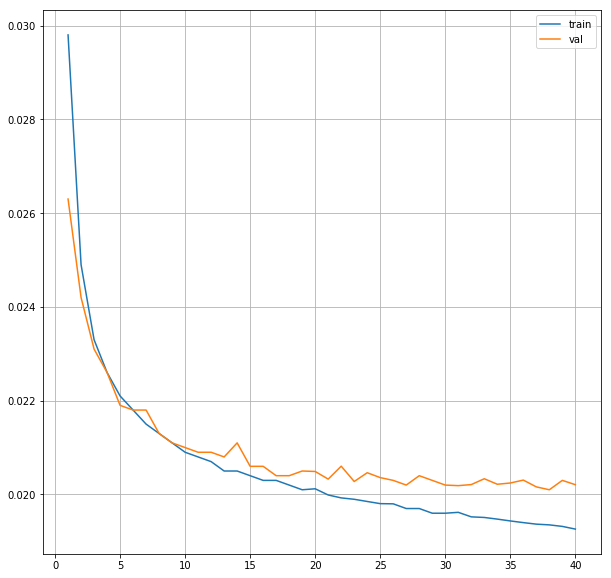

In [9]:
mt.plotHistory(training.history)

In [10]:
mt.toCSV("16/history.csv",training.history)

### Training with perceptual loss

In [4]:
model = Model()
model.load_state_dict(torch.load("16/weights40.pth"))
loss = lo.CombinedLoss(-18,0.00001)
training = Training(model,device,X_train, y_train, X_val, y_val, loss_function=loss)

In [7]:
try:
    training.fit(32, 5,val=True,save="16/comb/",save_off=5)
except KeyboardInterrupt:
    print("\n\nFinished training.")



====== TRAINING ======
===> Epoch[6](2112/2112): Loss: 0.0314	ETA 0:00:00	Epoch Loss: 0.0351
Epoch[6] finished in 0:03:17 with loss 0.03514323934425854
Validating on 16896 samples.
===> Validating (528/528):	ETA 0:00:00	Validation Loss: 0.0361
Validation loss = 0.0361

----------------------------

===> Epoch[7](2112/2112): Loss: 0.0317	ETA 0:00:00	Epoch Loss: 0.0351
Epoch[7] finished in 0:03:17 with loss 0.03510727154560189
Validating on 16896 samples.
===> Validating (528/528):	ETA 0:00:00	Validation Loss: 0.0361
Validation loss = 0.0361

----------------------------

===> Epoch[8](2112/2112): Loss: 0.0315	ETA 0:00:00	Epoch Loss: 0.0351
Epoch[8] finished in 0:03:16 with loss 0.03505600736278928
Validating on 16896 samples.
===> Validating (528/528):	ETA 0:00:00	Validation Loss: 0.0359
Validation loss = 0.0359

----------------------------

===> Epoch[9](2112/2112): Loss: 0.0316	ETA 0:00:00	Epoch Loss: 0.0350
Epoch[9] finished in 0:03:15 with loss 0.03500533739288309
Validating on 1

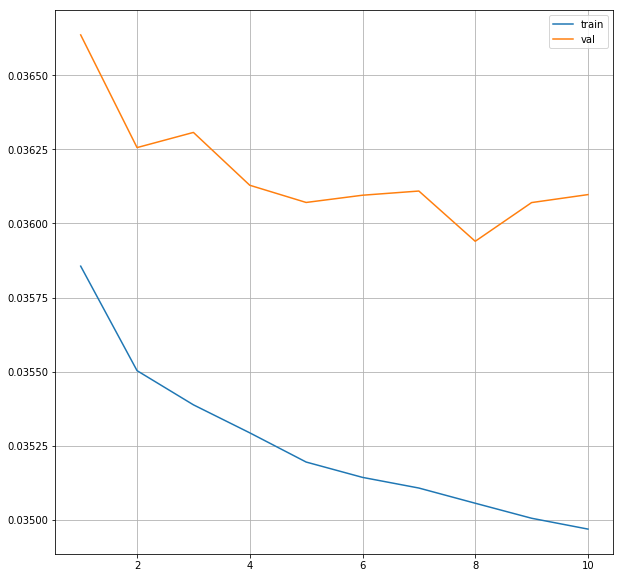

In [8]:
mt.plotHistory(training.history)
mt.toCSV("16/comb/history.csv",training.history)

--------------------------

In [ ]:
!cp weights1 gdrive/My\ Drive/16/combined_2e-5/weights1
!cp weights2 gdrive/My\ Drive/16/combined_2e-5/weights2
# !cp weights6 gdrive/My\ Drive/16/weights25
mt.toCSV("tmp.csv",training.history)
!cp tmp.csv gdrive/My\ Drive/16/combined_2e-5/.

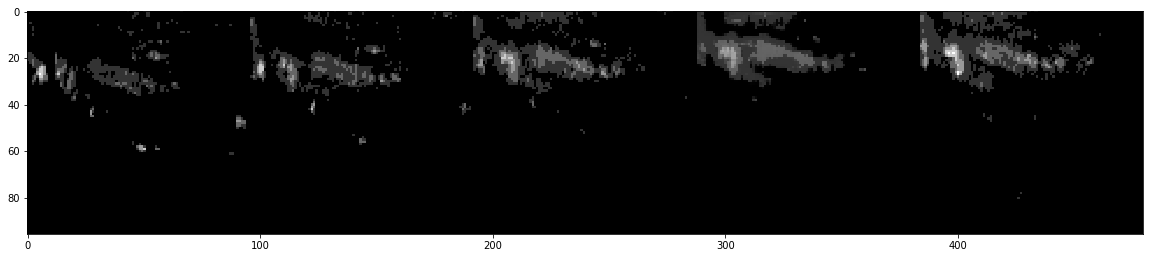

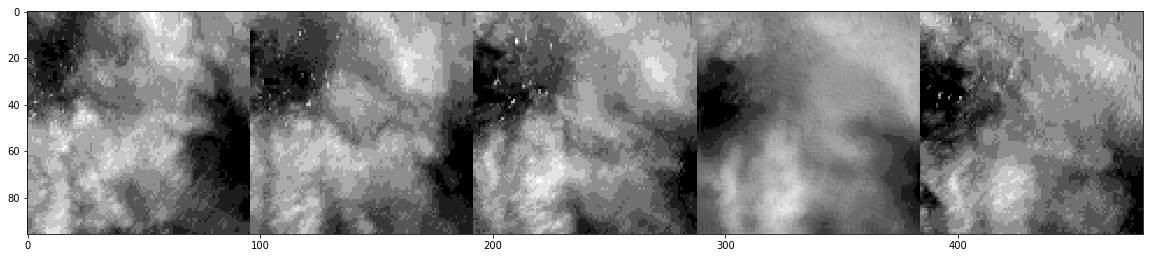

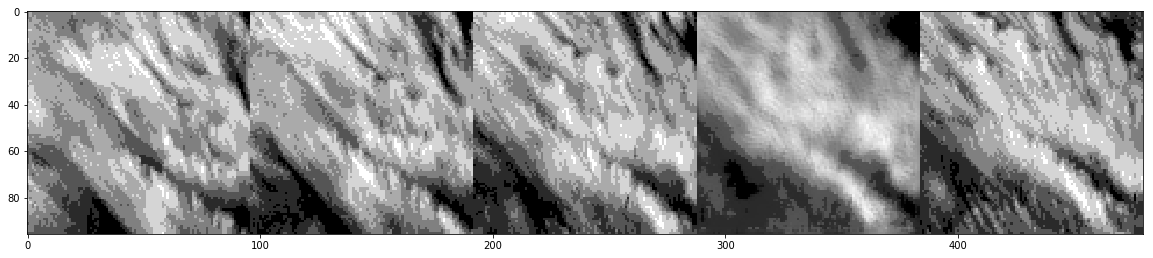

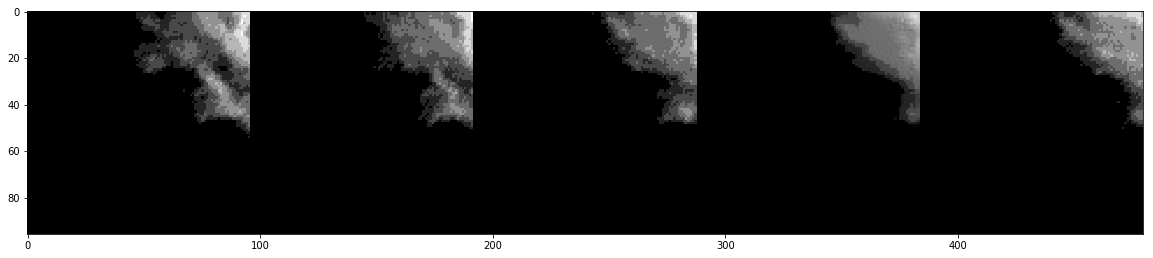

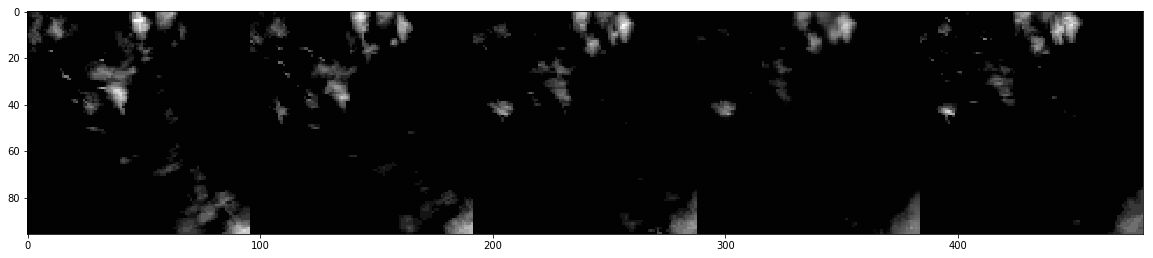

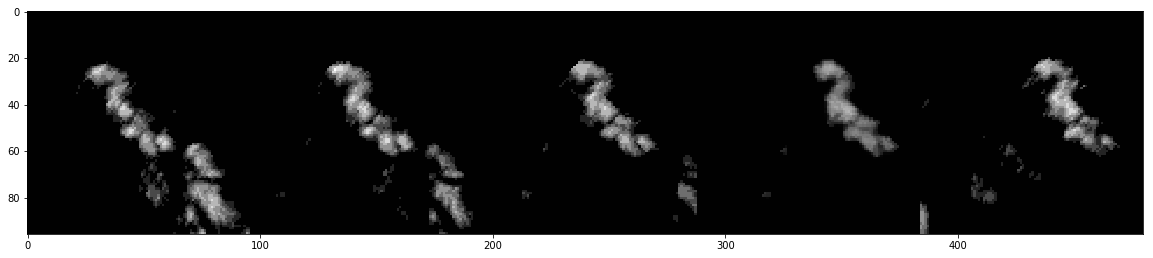

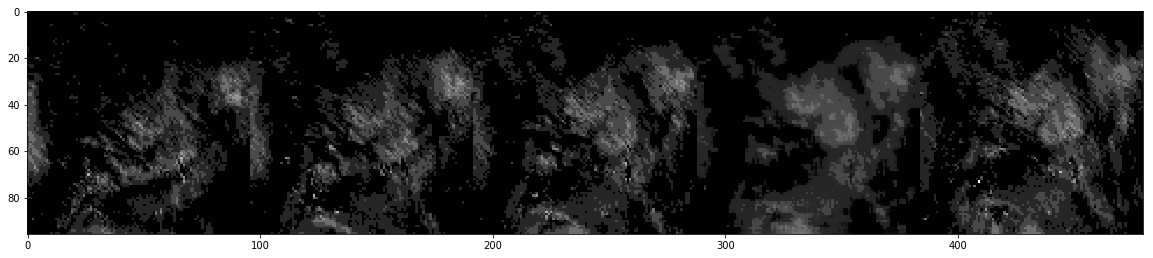

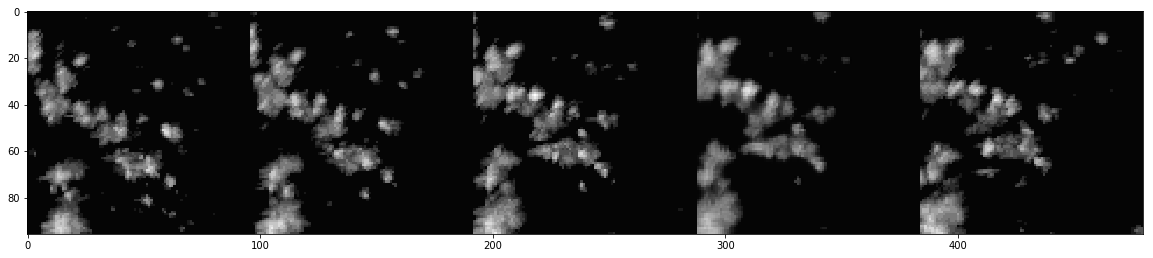

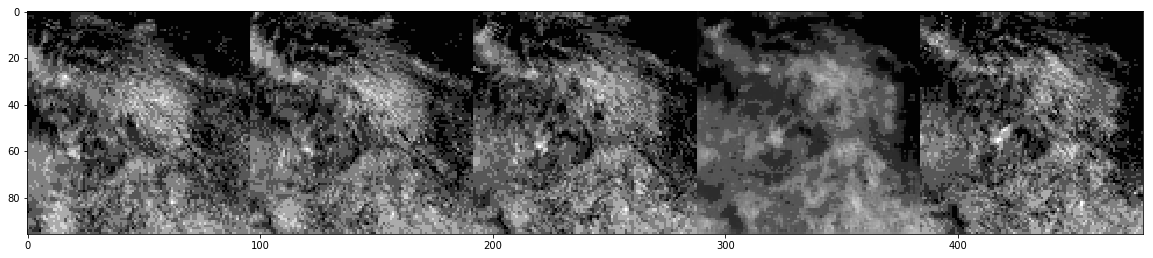

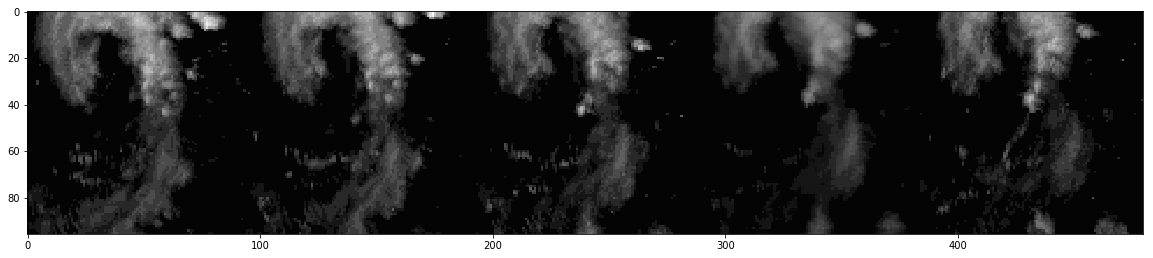

In [ ]:
!mkdir -p img

out = model( torch.tensor(X_train[0:10], dtype=torch.float).to(device) ).cpu().detach().numpy()
for i in range(10):
    mt.showImgGC(str(i), X_train[i,0],X_train[i,1],X_train[i,2],out[i,0], y_train[i,0], folder='img/',size=(20,20))

(1, 3, 1, 96, 96)


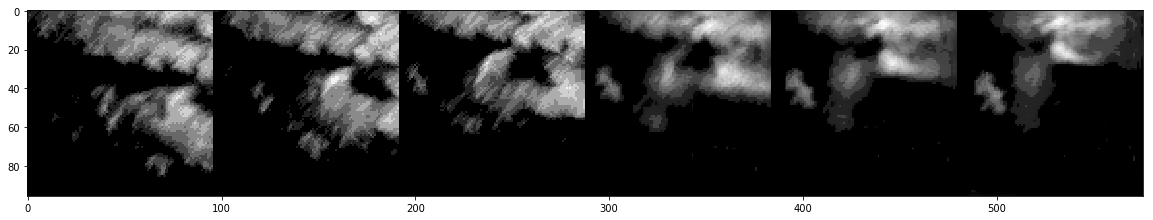

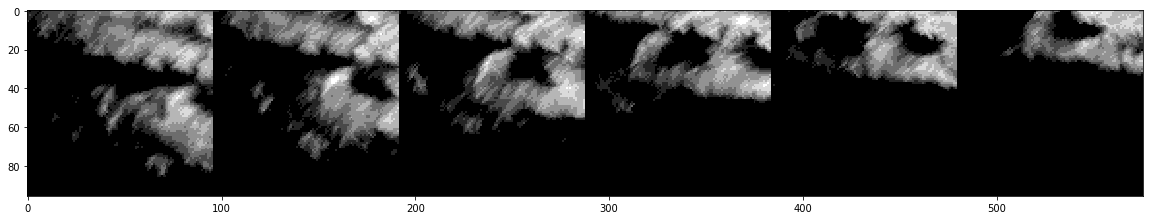

In [ ]:
i = 47

out = model.predict( torch.tensor(X_train[i:i+1], dtype=torch.float).to(device), 3 ).cpu().detach().numpy()
print(out.shape)
out = out.reshape((1,3,96,96))
mt.showImgGC("pred_my",X_train[i,0],X_train[i,1],X_train[i,2],out[0,0],out[0,1],out[0,2],folder="",size=(20,20))
mt.showImgGC("pred_gt",X_train[i,0],X_train[i,1],X_train[i,2],y_train[i,0],y_train[i,1],y_train[i,2],folder="",size=(20,20))

# for i in range(10):
# mt.showImgGC(str(i), X_train[i,0],X_train[i,1],X_train[i,2],out[i,0], y_train[i,0], folder='img/',size=(20,20))

(1, 3, 96, 96)


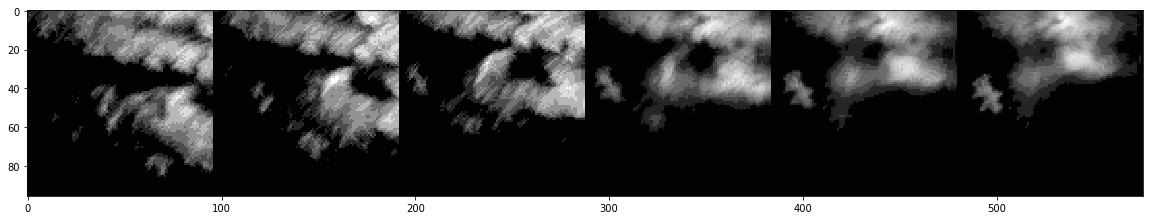

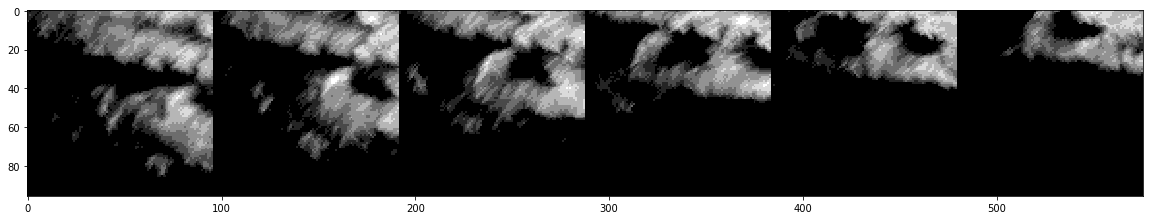

In [21]:
i = 47

out = model.predict( torch.tensor(X_train[i:i+1], dtype=torch.float).to(device), 3 ).cpu().detach().numpy()
print(out.shape)
out = out.reshape((1,3,96,96))
mt.showImgGC("pred_my",X_train[i,0],X_train[i,1],X_train[i,2],out[0,0],out[0,1],out[0,2],folder="",size=(20,20))
mt.showImgGC("pred_gt",X_train[i,0],X_train[i,1],X_train[i,2],y_train[i,0],y_train[i,1],y_train[i,2],folder="",size=(20,20))


In [ ]:
!mkdir -p img
for i in range(3):
    mt.showImgGC(str(i),X_train[47,i],folder="img/")
for i in range(3):
    mt.showImgGC(str(i+3),y_train[47,i],folder="img/")

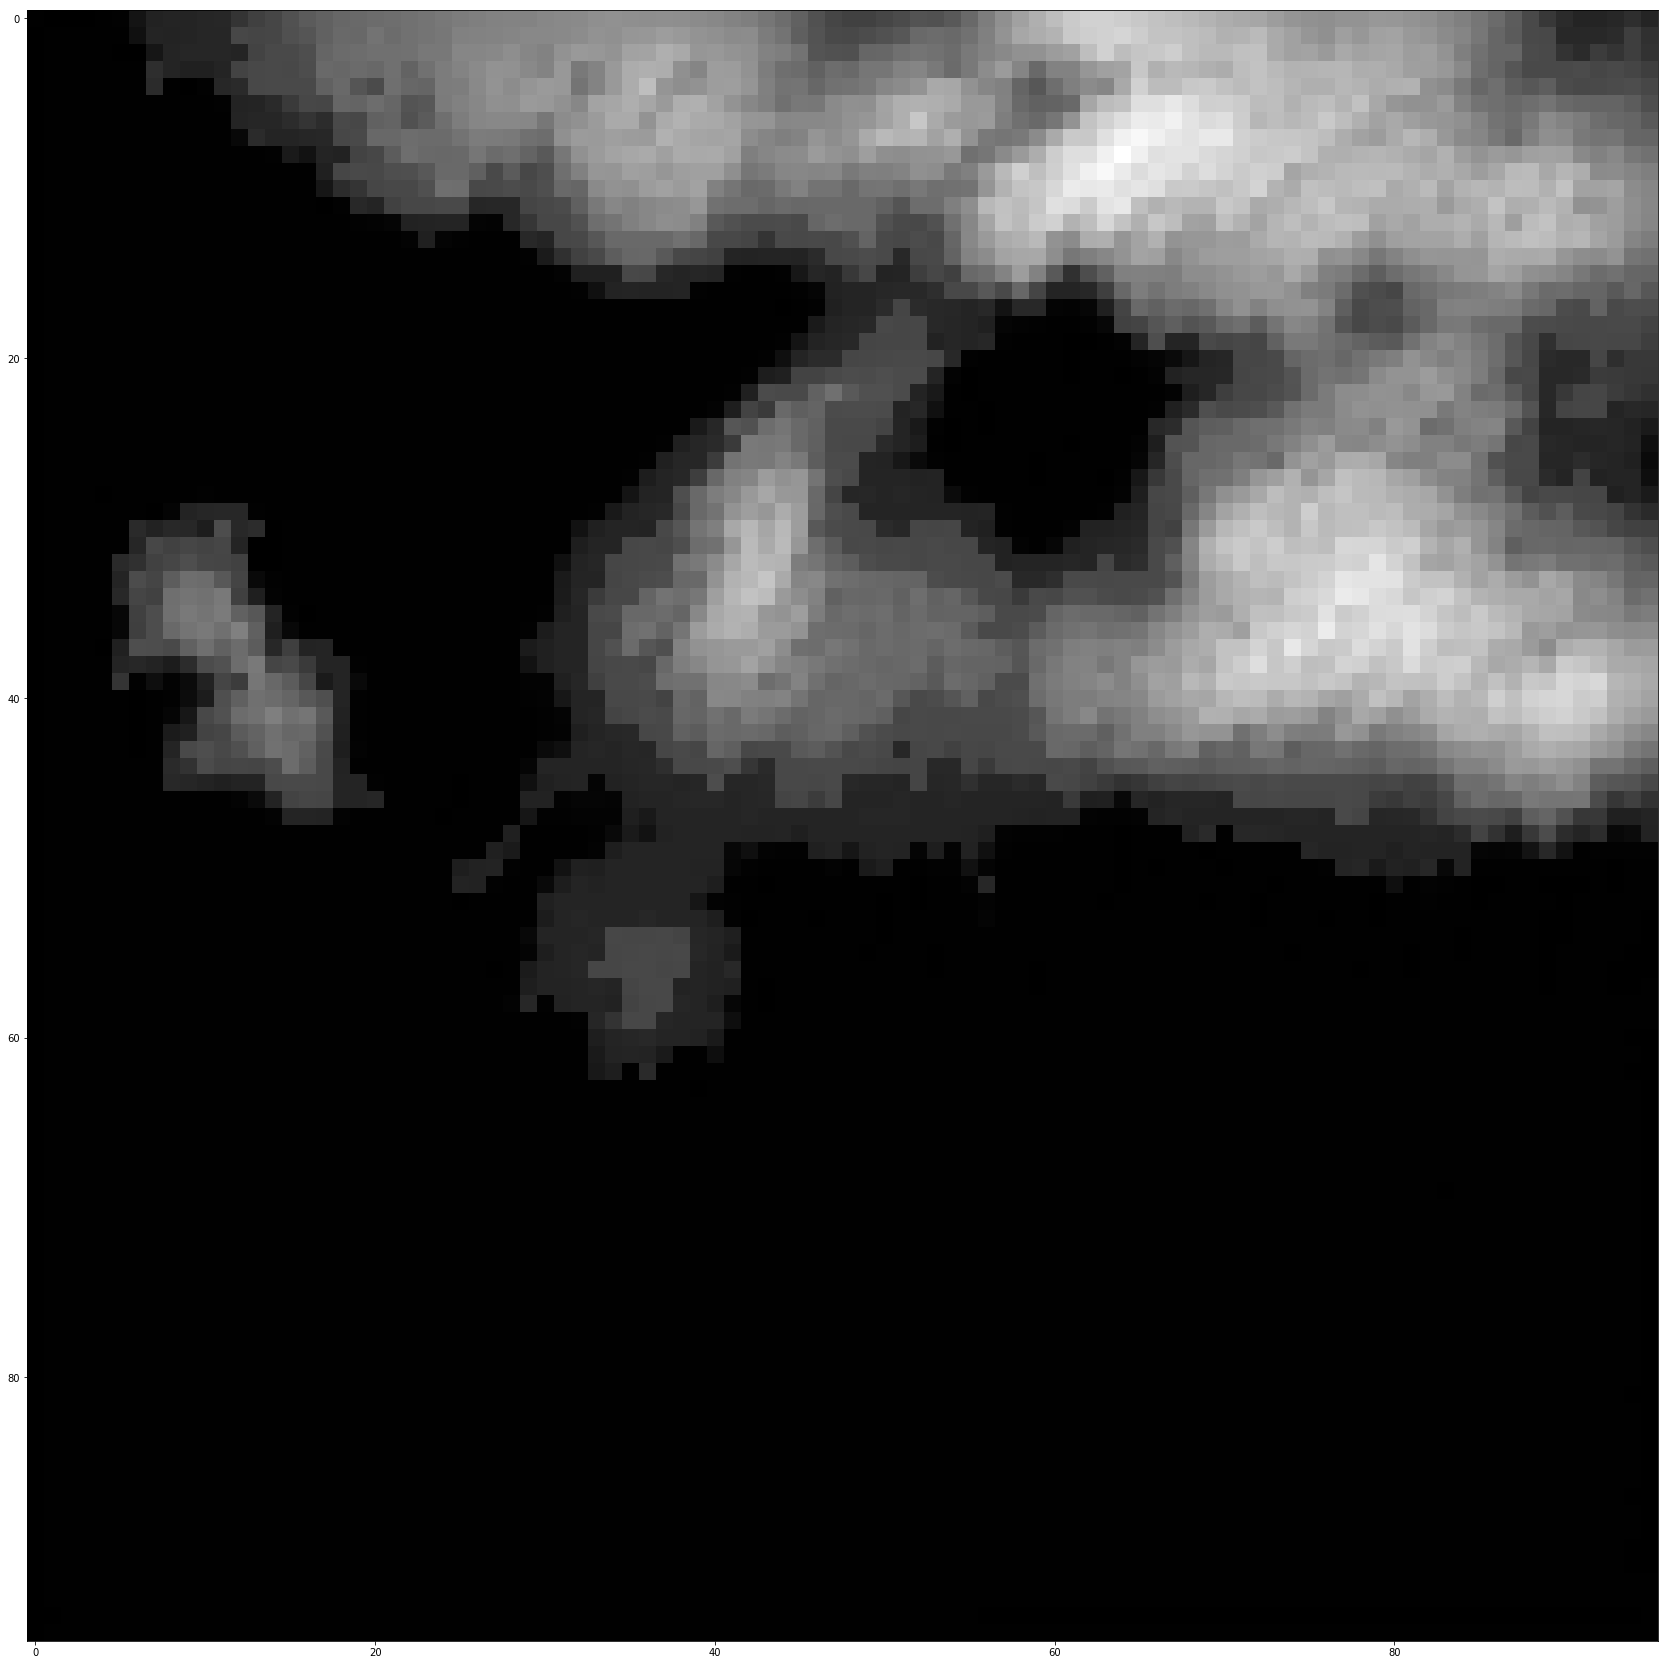

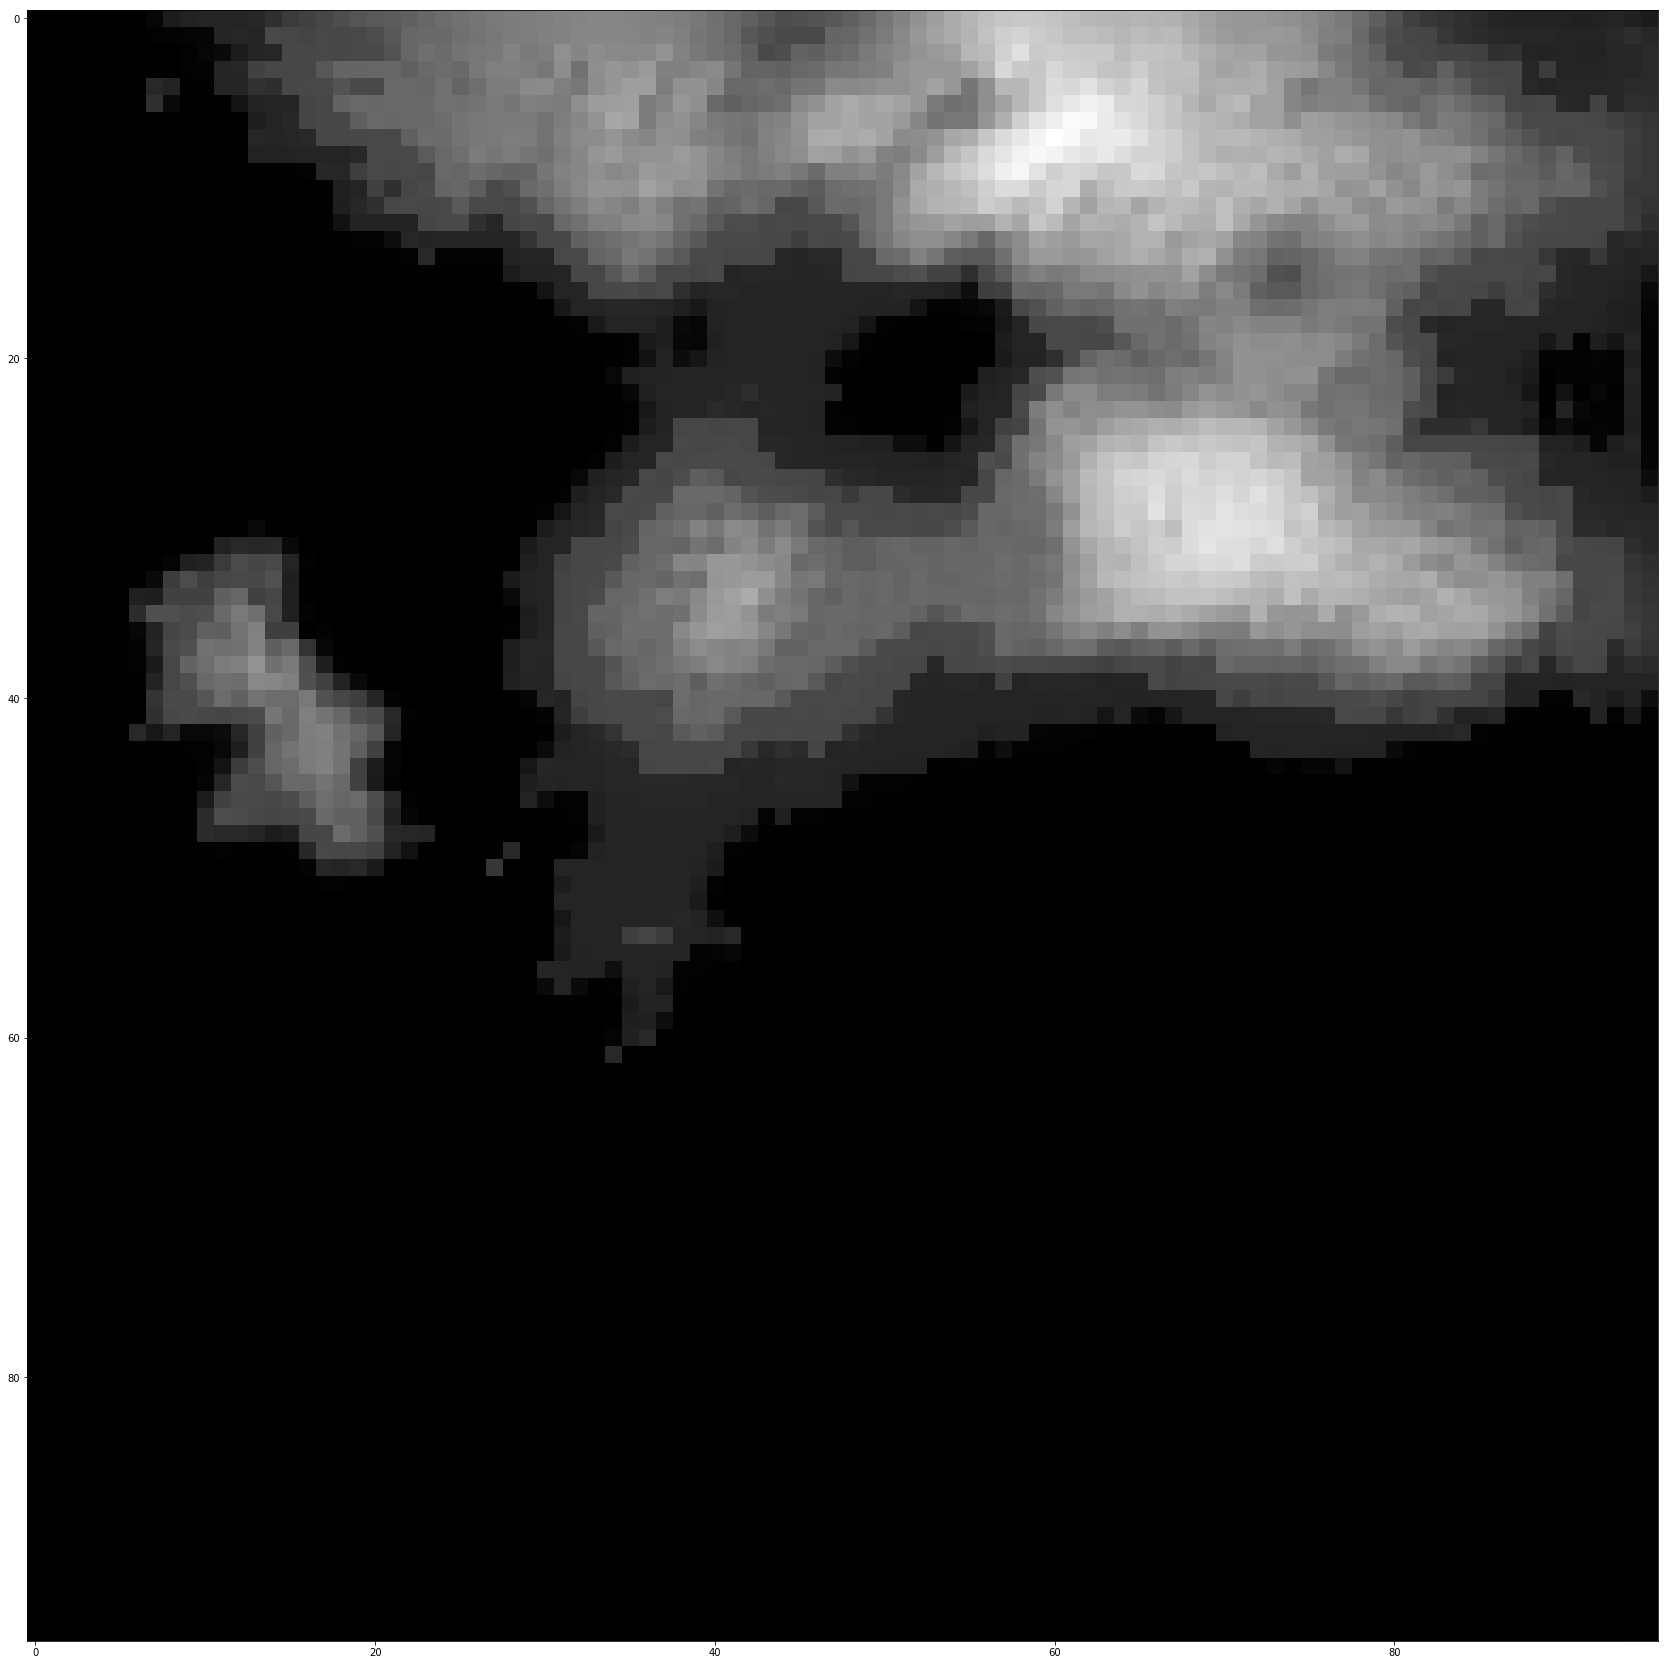

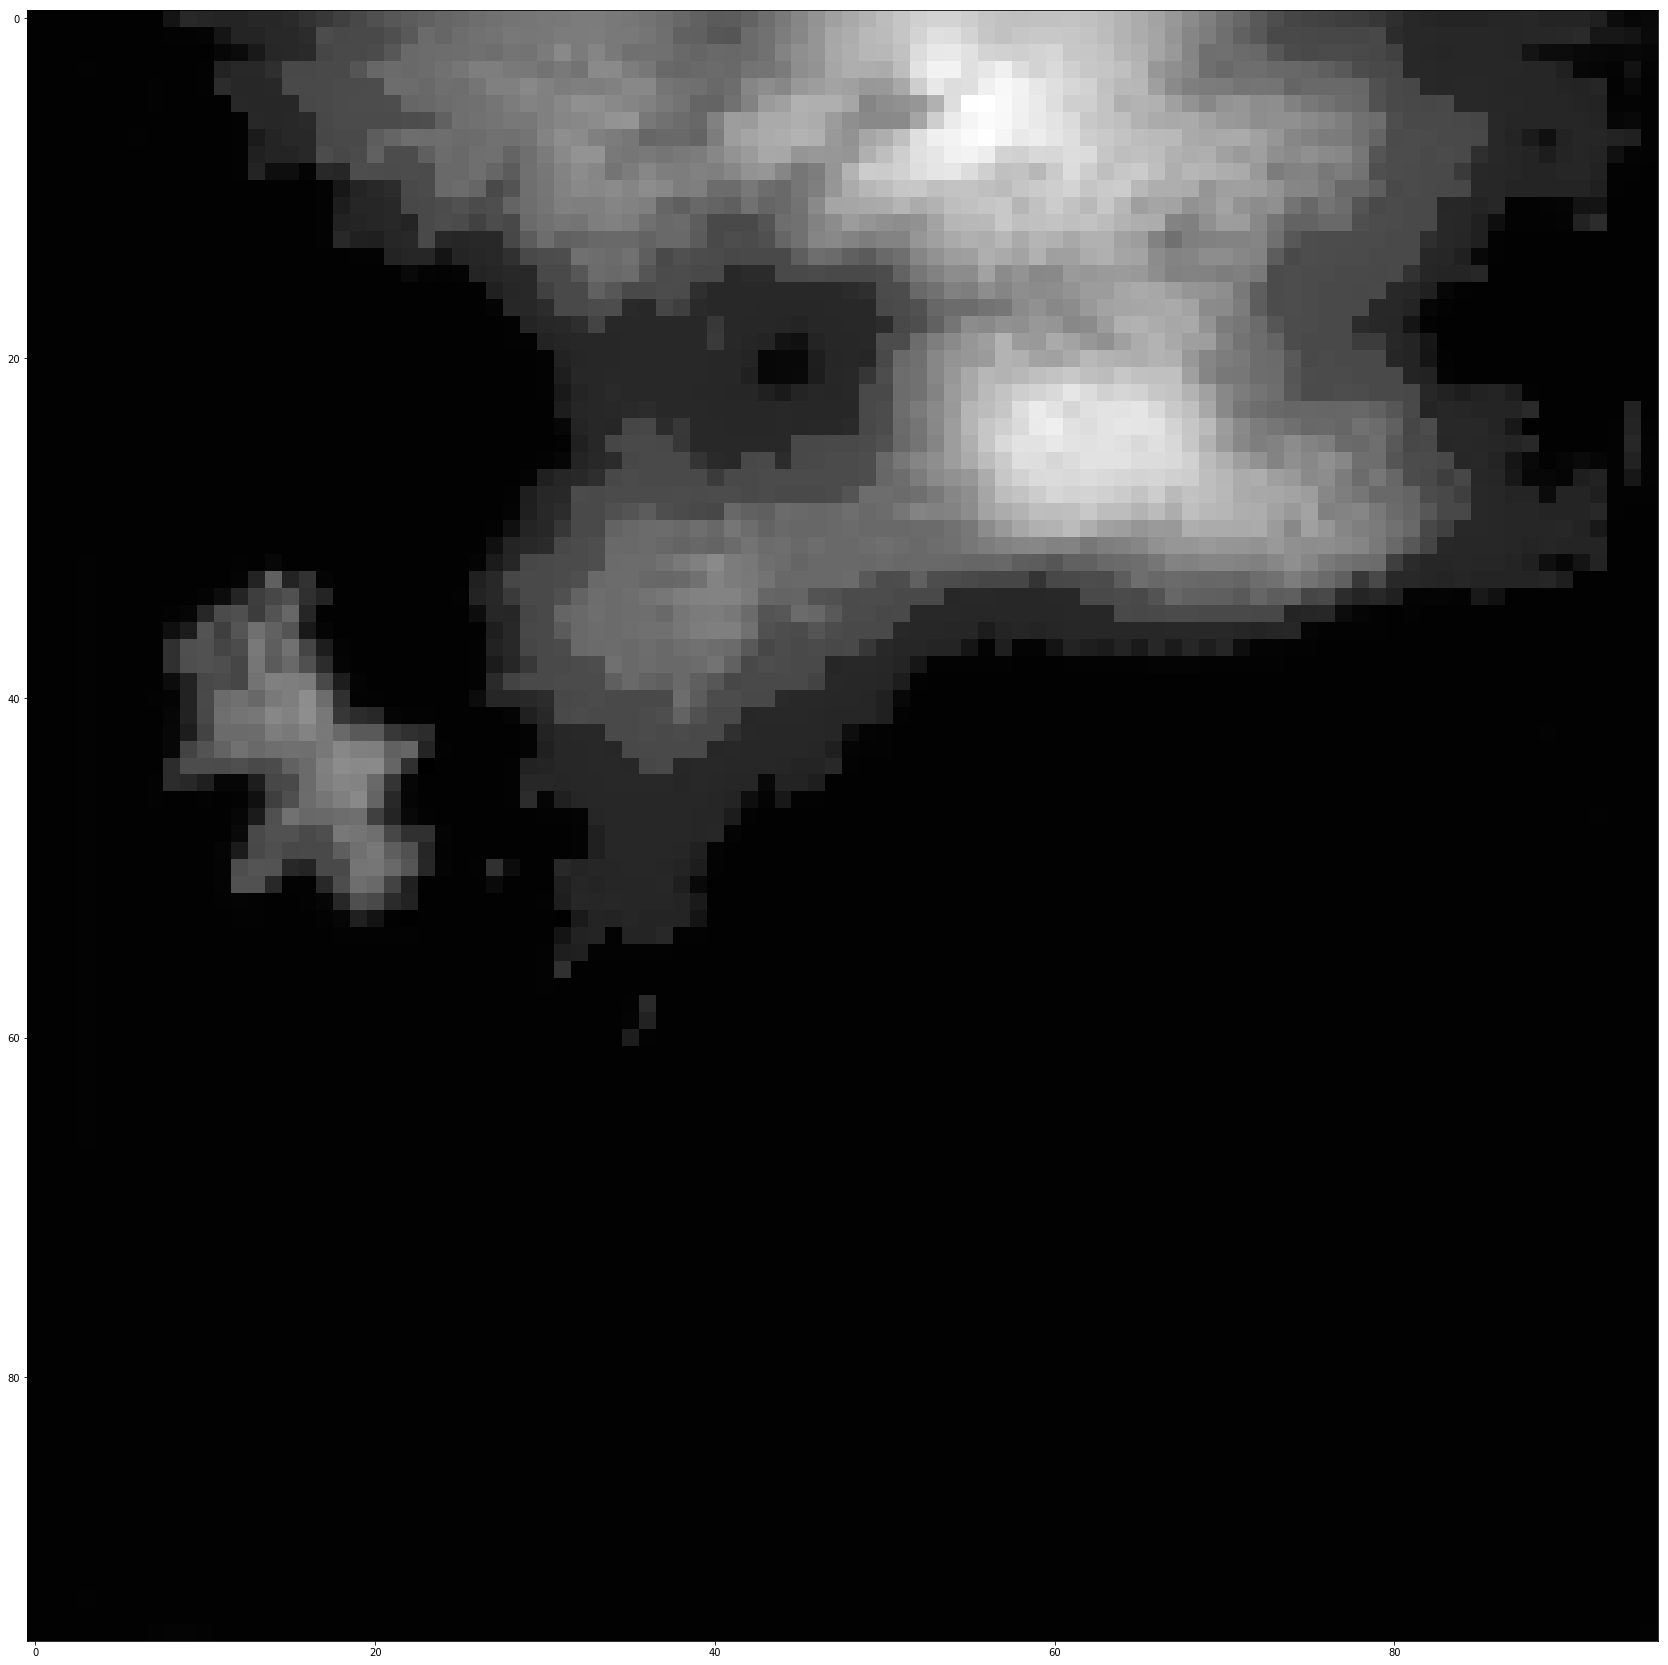

In [24]:
out = model.predict( torch.tensor(X_train[47:48], dtype=torch.float).to(device), 3 ).cpu().detach().numpy()
for i in range(3):
    mt.showImgGC("out_"+str(i),out[0,i],folder="img/")

In [25]:
!zip fig.zip img/*.png
# !cp fig.zip gdrive/My\ Drive/16/.

  adding: img/0.png (stored 0%)
  adding: img/1.png (stored 0%)
  adding: img/2.png (deflated 2%)
  adding: img/3.png (deflated 3%)
  adding: img/4.png (deflated 7%)
  adding: img/5.png (deflated 9%)
  adding: img/out_0.png (deflated 1%)
  adding: img/out_1.png (deflated 1%)
  adding: img/out_2.png (deflated 0%)


In [ ]:
training.history

{'train': [0.033530190842804695, 0.03307374570673952], 'val': []}